In [1]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
# print(os.listdir("../input"))

In [2]:
# Define Constants
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [3]:
# Prepare Training Data
filenames = os.listdir("C:/Users/MYCOM/Downloads/train (1)/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [4]:
df.head()

filename  category
0     cat.0.jpg         0
1     cat.1.jpg         0
2    cat.10.jpg         0
3   cat.100.jpg         0
4  cat.1000.jpg         0

In [5]:
df.tail()

filename  category
24995  dog.9995.jpg         1
24996  dog.9996.jpg         1
24997  dog.9997.jpg         1
24998  dog.9998.jpg         1
24999  dog.9999.jpg         1

<AxesSubplot:>

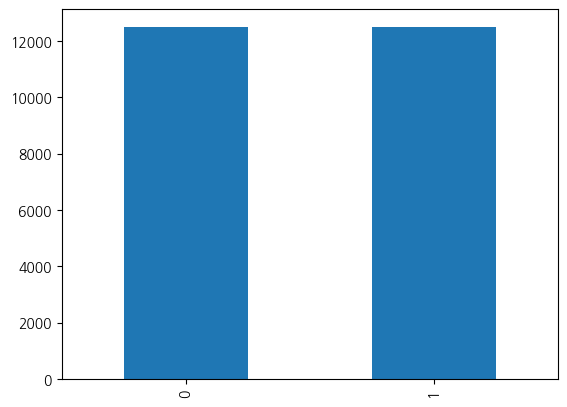

In [6]:
# See total in count
df['category'].value_counts().plot.bar()

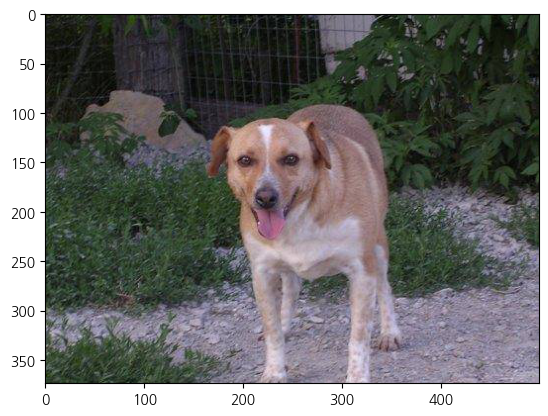

In [7]:
# See sample image
sample = random.choice(filenames)
image = load_img("C:/Users/MYCOM/Downloads/train (1)/train/"+sample)
plt.imshow(image)

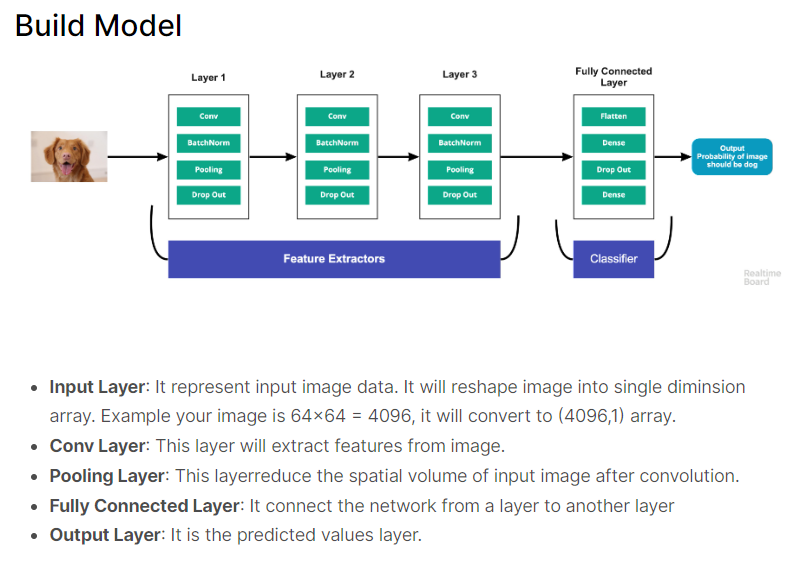

In [8]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 126, 126, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 61, 61, 64)        2

In [9]:
# CallBacks
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
# EarlyStopping
earlystop = EarlyStopping(patience=10)

In [10]:
# Learning Rate Reduction
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
callbacks = [earlystop, learning_rate_reduction]

In [11]:
# Prepare Data
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

<AxesSubplot:>

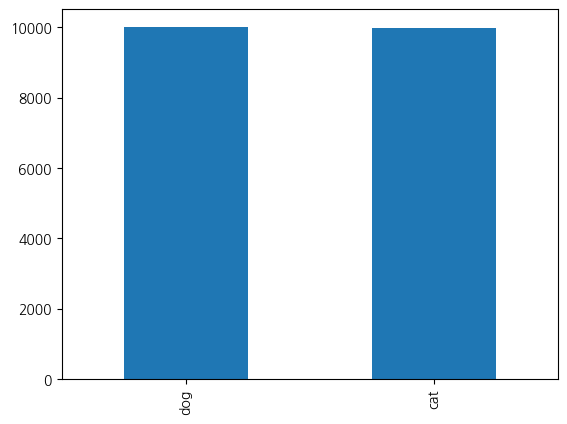

In [13]:
train_df['category'].value_counts().plot.bar()

<AxesSubplot:>

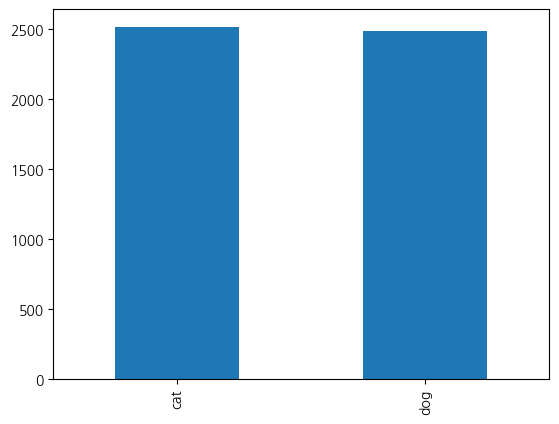

In [14]:
validate_df['category'].value_counts().plot.bar()

In [15]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

In [16]:
# Training Generator
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "C:/Users/MYCOM/Downloads/train (1)/train", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


In [18]:
# Validation Generator
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "C:/Users/MYCOM/Downloads/train (1)/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


In [19]:
# See how our genator work
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "C:/Users/MYCOM/Downloads/train (1)/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


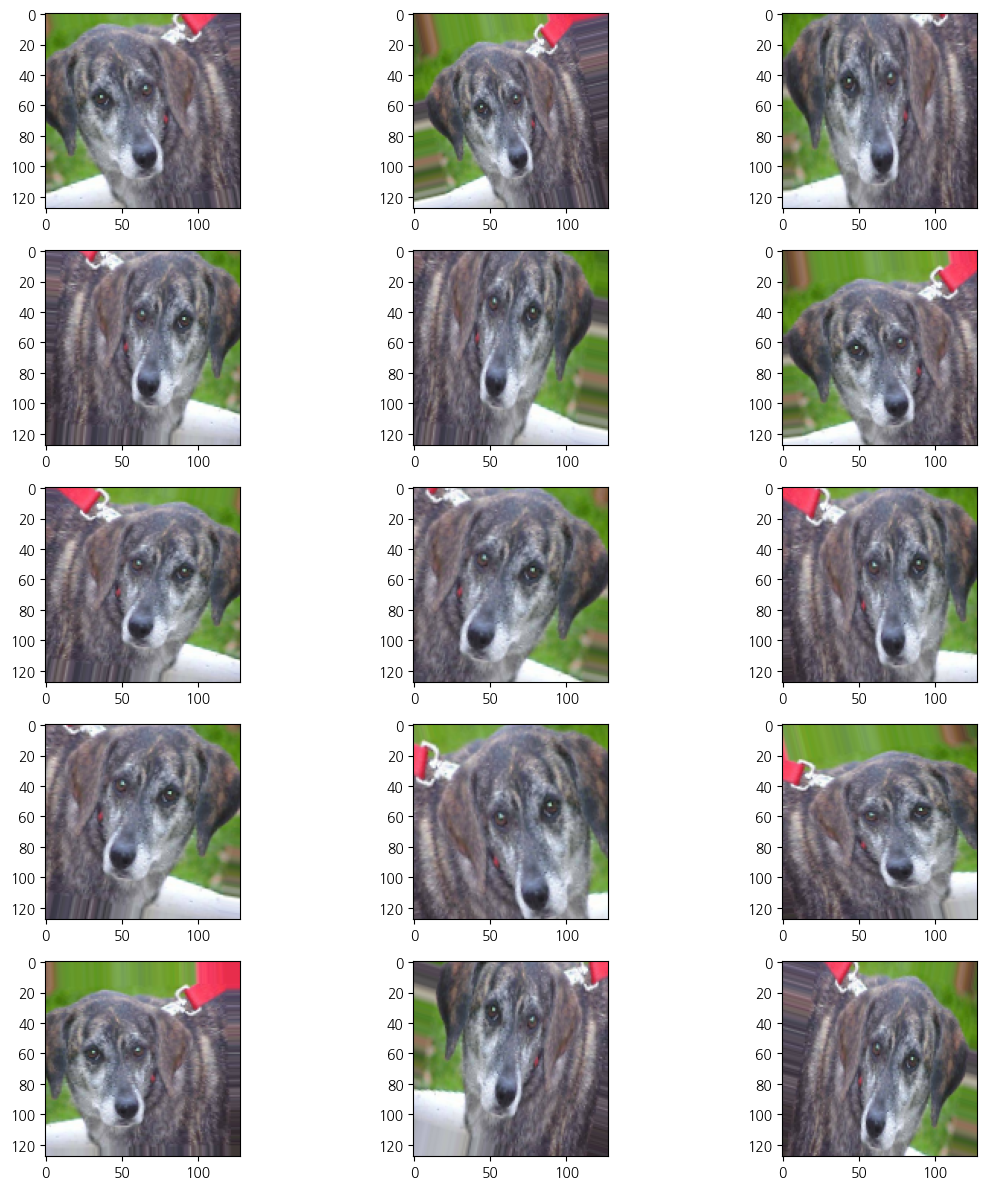

In [20]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [21]:
# Fit model
epochs=3 if FAST_RUN else 5
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

C:\Users\MYCOM\AppData\Local\Temp\ipykernel_24788\3047368677.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/5
1333/1333 [==============================] - 963s 721ms/step - loss: 0.7343 - accuracy: 0.6308 - val_loss: 0.5490 - val_accuracy: 0.7213 - lr: 0.0010
Epoch 2/5
1333/1333 [==============================] - 755s 566ms/step - loss: 0.5620 - accuracy: 0.7193 - val_loss: 2.0924 - val_accuracy: 0.5109 - lr: 0.0010
Epoch 3/5
1333/1333 [==============================] - 712s 534ms/step - loss: 0.5041 - accuracy: 0.7596 - val_loss: 0.4319 - val_accuracy: 0.7998 - lr: 0.0010
Epoch 4/5
1333/1333 [==============================] - 525s 394ms/step - loss: 0.4718 - accuracy: 0.7833 - val_loss: 0.7849 - val_accuracy: 0.6685 - lr: 0.0010
Epoch 5/5
1333/1333 [==============================] - 528s 396ms/step - loss: 0.4402 - accuracy: 0.7982 - val_loss: 0.4276 - val_accuracy: 0.7956 - lr: 0.0010


In [22]:
# Save Model
model.save_weights("model.h5")

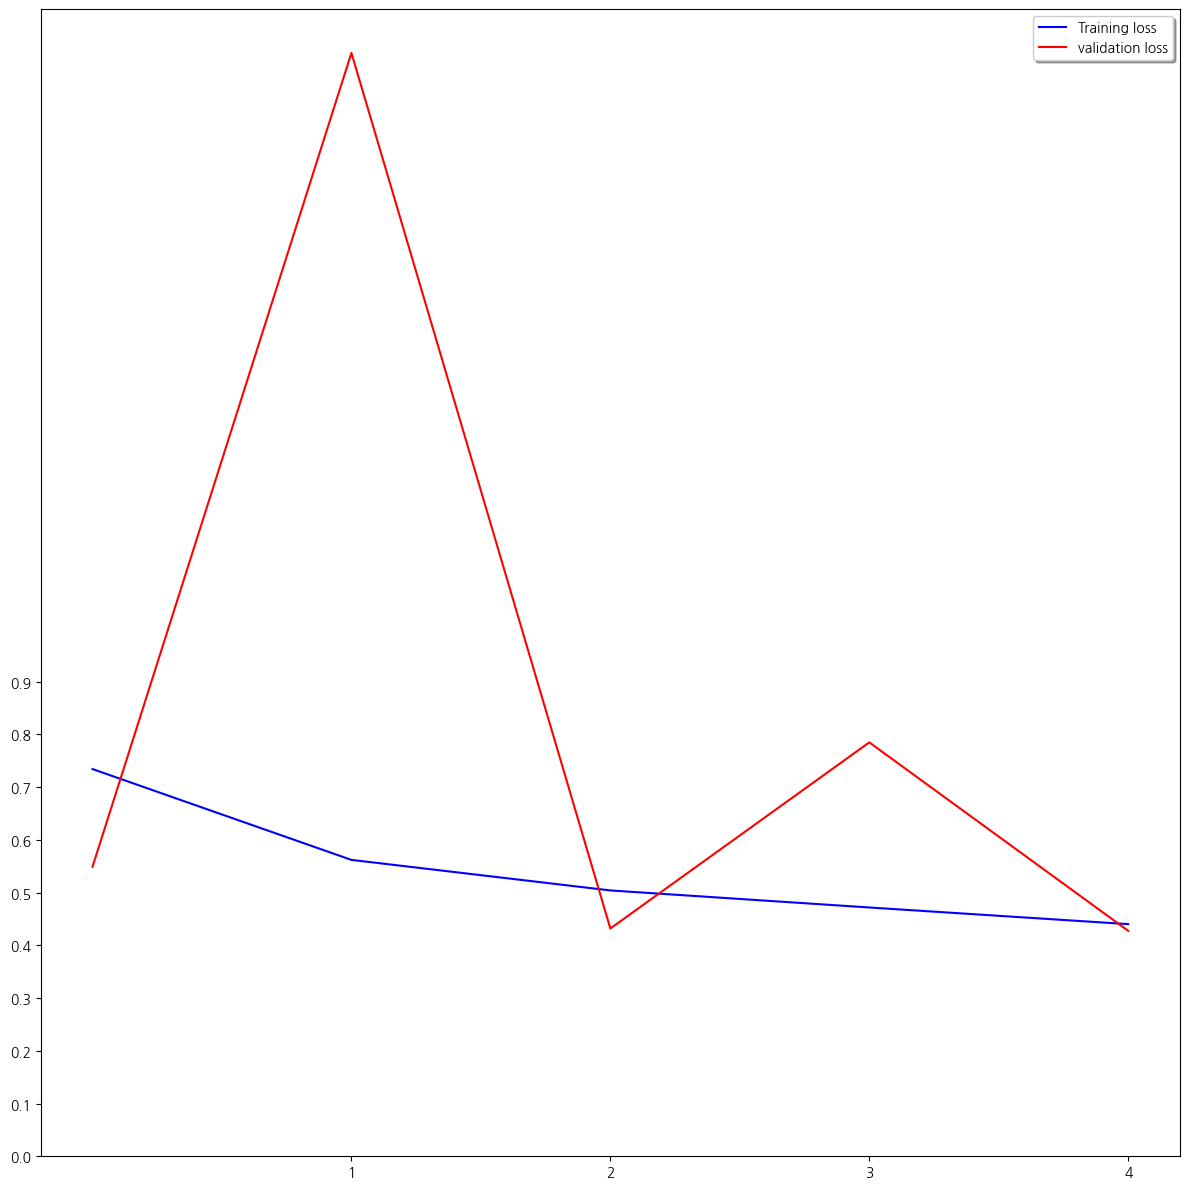

In [28]:
# Virtualize Training
fig, ax1 = plt.subplots(1, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

#ax2.plot(history.history['acc'], color='b', label="Training accuracy")
#ax2.plot(history.history['val_acc'], color='r',label="Validation accuracy")
#ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [29]:
# Prepare Testing Data
test_filenames = os.listdir("C:/Users/MYCOM/Downloads/test1 (2)/test1")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [31]:
# Create Testing Generator
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "C:/Users/MYCOM/Downloads/test1 (2)/test1/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 12500 validated image filenames.


In [32]:
# Predict
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))
test_df['category'] = np.argmax(predict, axis=-1)

C:\Users\MYCOM\AppData\Local\Temp\ipykernel_24788\4098067128.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))


In [33]:
# Convert the predict category back into our generator classes
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

In [34]:
# We will map the result back to dog is 1 and cat is 0
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

<AxesSubplot:>

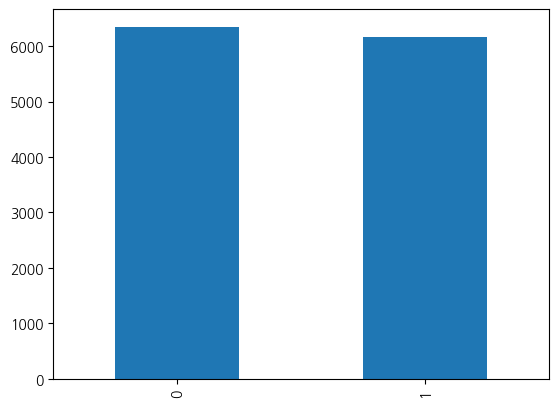

In [35]:
# Virtualize Result
test_df['category'].value_counts().plot.bar()

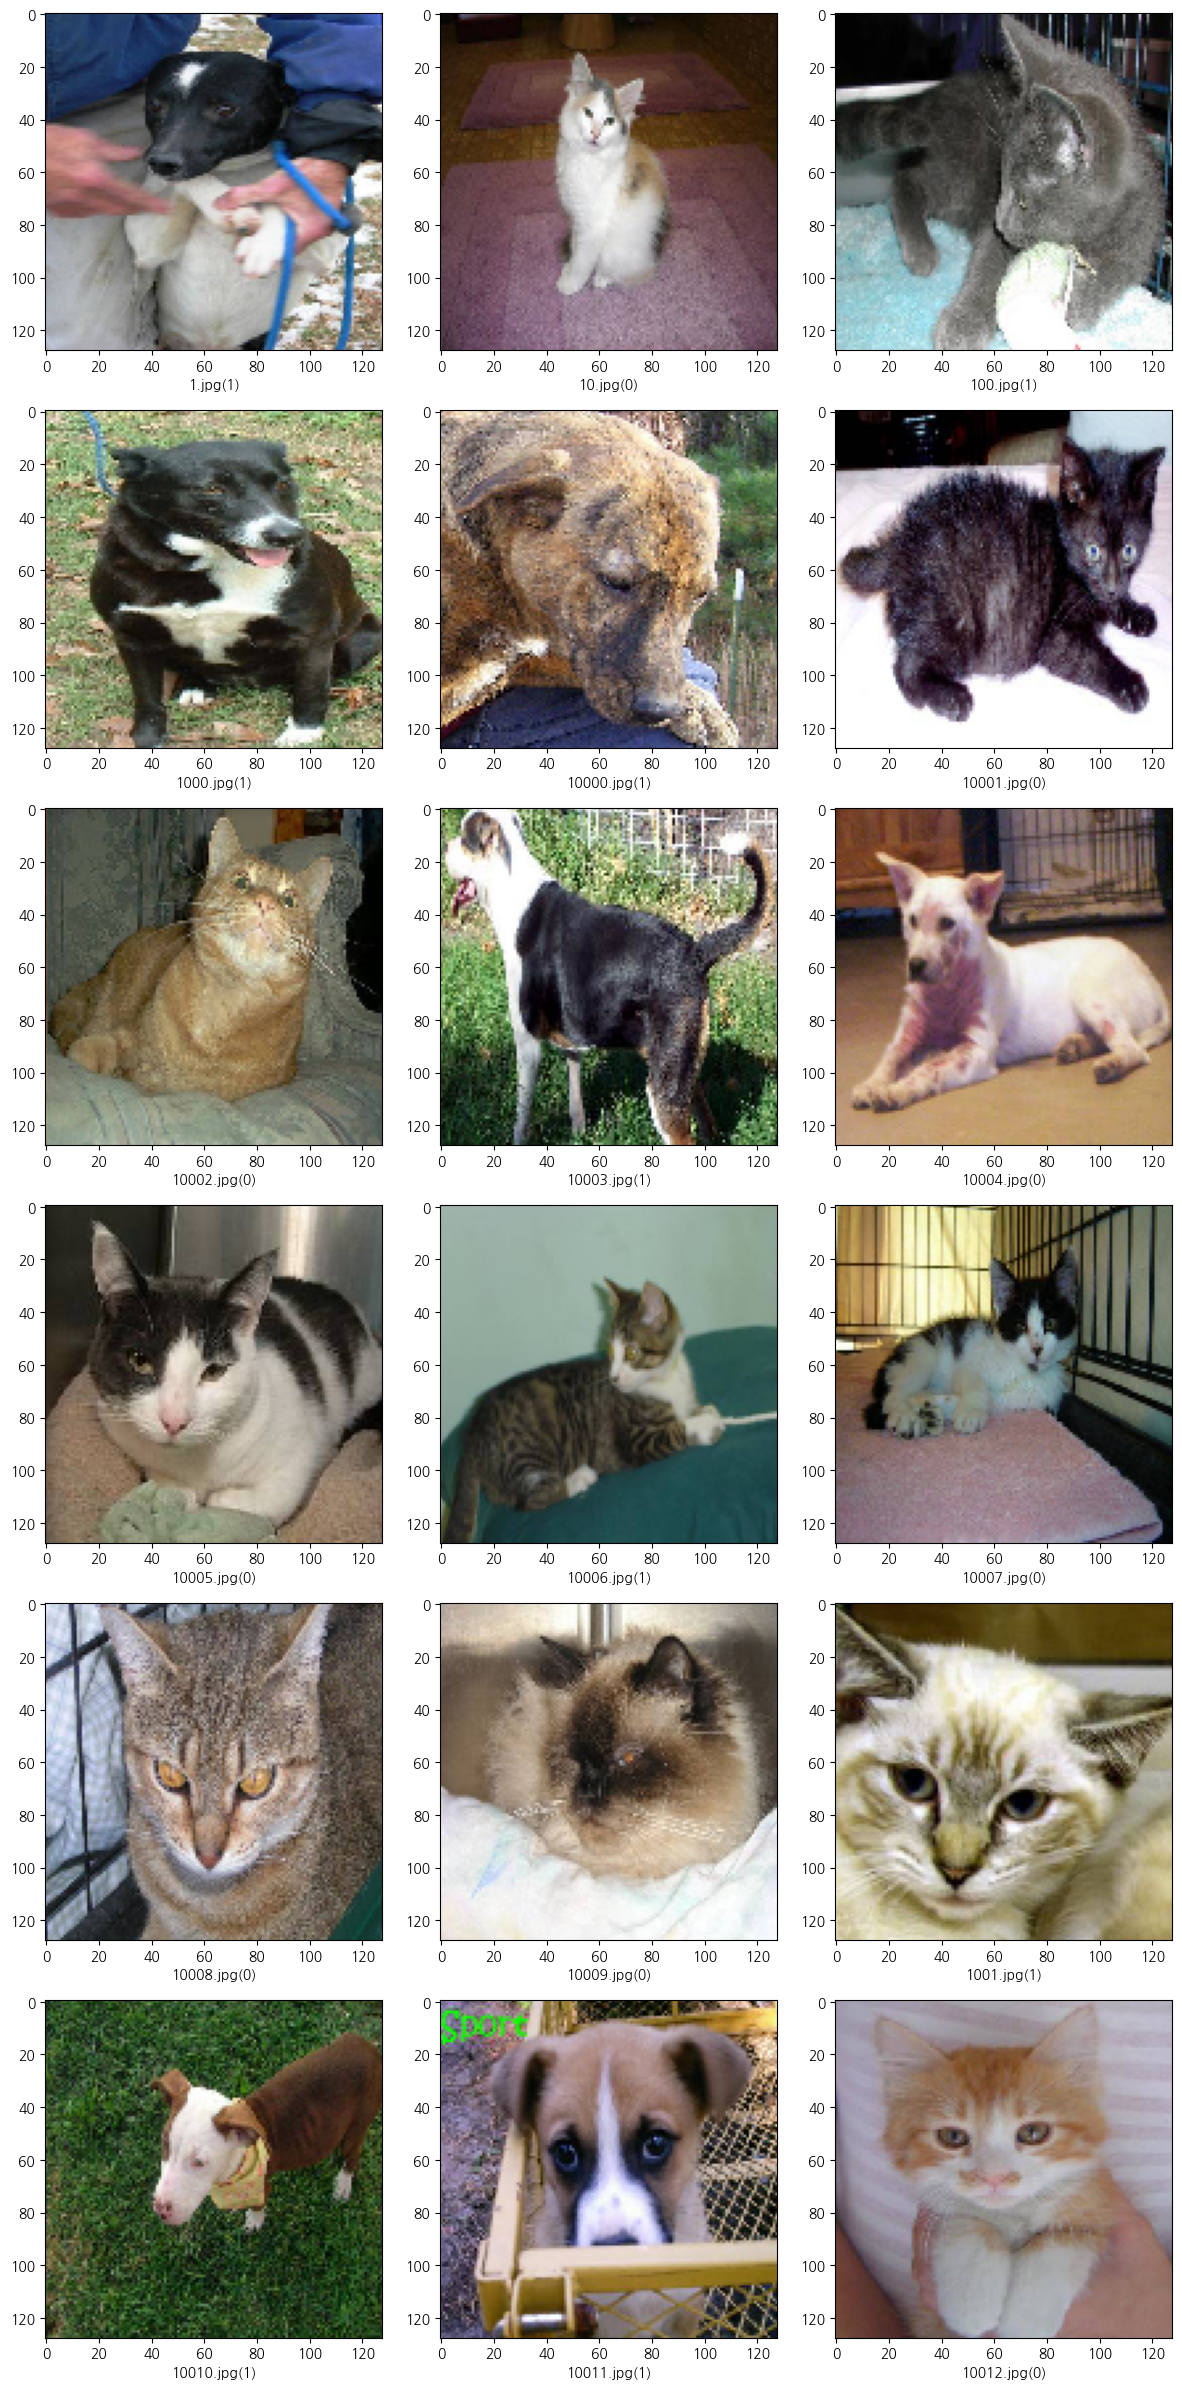

In [37]:
# See predicted result with images
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("C:/Users/MYCOM/Downloads/test1 (2)/test1/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

In [ ]:
# Submission
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('submission.csv', index=False)